In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from prophet import Prophet
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

In [9]:

datetime_features = ['dayofweek', 'month', 'hour', 'minute', 'is_weekend']

def get_masked_data(df: pd.DataFrame):
    # Define the start and end timestamps
    start_timestamp = pd.to_datetime('2023-01-01 08:00:00')
    end_timestamp = pd.to_datetime('2023-12-31 08:00:00')

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    result_df = df[mask]

    #filter values that are less then 0 from polygon_1663
    result_df = result_df[result_df['polygon_1663'] >= 0]

    result_df.fillna(0, inplace=True)

    return result_df


def to_input(df: pd.DataFrame):
    df['polygon_1663'].fillna(0, inplace=True)

    return df

df = pd.read_parquet("../data/rucphen_precipitation_clean.parquet")
df = get_masked_data(df)
df = to_input(df)




In [10]:
# Use 'polygon_1663' as the feature of interest
df.set_index('timestamp', inplace=True)

# Creating lagged features, rolling means, etc.
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['polygon_1663'].shift(lag)
df['rolling_mean'] = df['polygon_1663'].rolling(window=3).mean()

# Dropping NaN values created by lags
df.dropna(inplace=True)

df.head()


,polygon_1663,percentage,lag_1,lag_2,lag_3,rolling_mean
timestamp,,,,,,
2023-01-01 08:15:00,0.0,7.018,0.0,0.01,0.02,0.003333
2023-01-01 08:20:00,0.0,7.018,0.0,0.00,0.01,0.000000
2023-01-01 08:25:00,0.0,7.018,0.0,0.00,0.00,0.000000
2023-01-01 08:30:00,0.0,7.018,0.0,0.00,0.00,0.000000
2023-01-01 08:35:00,0.0,7.018,0.0,0.00,0.00,0.000000


In [11]:
X = df.drop('percentage', axis=1)
y = df['percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [12]:
# Automatically fitting an ARIMA model
model_arima = pm.auto_arima(y_train, seasonal=False, m=1, suppress_warnings=True)
predictions = model_arima.predict(n_periods=len(y_test))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))

c:\Users\Optic\anaconda3\envs\capstonev2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Optic\anaconda3\envs\capstonev2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA RMSE: 26.34890029015233


12:49:19 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 25.792686048302627


  0%|          | 0/16 [00:00<?, ?it/s]12:50:14 - cmdstanpy - INFO - Chain [1] start processing
12:50:15 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:03<00:50,  3.36s/it]12:50:17 - cmdstanpy - INFO - Chain [1] start processing
12:50:21 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:08<01:03,  4.51s/it]12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:28 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:15<01:12,  5.59s/it]12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:34 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:21<01:08,  5.75s/it]12:50:36 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:30<01:16,  6.95s/it]12:50:45 - cmdstanpy - INFO - Chain [1] start processing
12:50:56 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 6/16 [00:43<01:31,  9.13s/it]12:50:59

          horizon         mse       rmse        mae     mdape     smape  \
0 1 days 12:55:00  317.647808  17.822677  10.674801  1.496341  1.121102   
1 1 days 13:00:00  316.634209  17.794218  10.669575  1.497948  1.121440   
2 1 days 13:05:00  315.624678  17.765829  10.664538  1.500440  1.121906   
3 1 days 13:10:00  314.620484  17.737544  10.659788  1.504201  1.122478   
4 1 days 13:15:00  313.624280  17.709440  10.655404  1.506054  1.123110   

   coverage  
0  0.926831  
1  0.926988  
2  0.927145  
3  0.927302  
4  0.927459  


c:\Users\Optic\anaconda3\envs\capstonev2\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Optic\anaconda3\envs\capstonev2\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


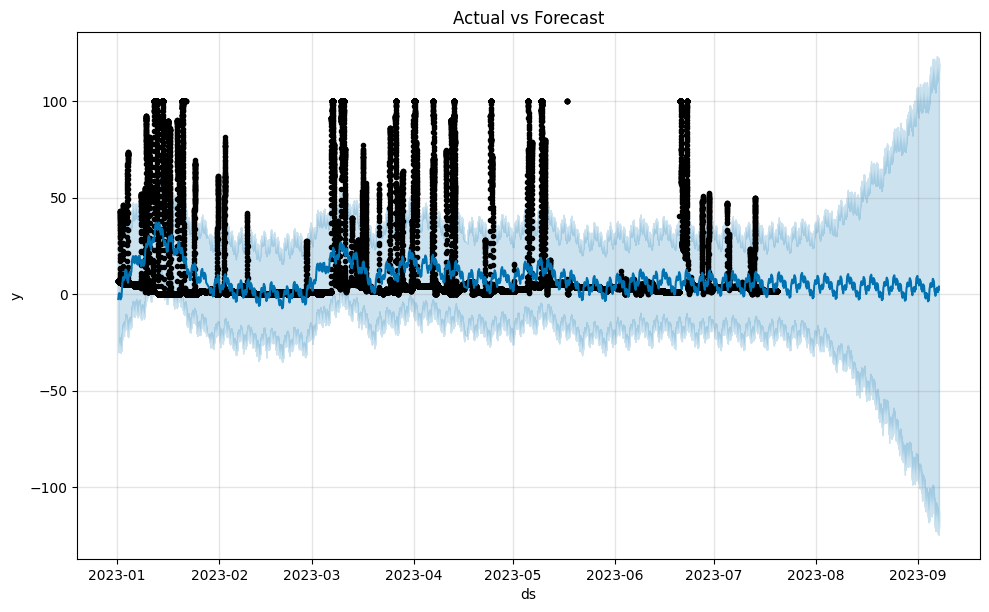

c:\Users\Optic\anaconda3\envs\capstonev2\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Optic\anaconda3\envs\capstonev2\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\Optic\anaconda3\envs\capstonev2\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

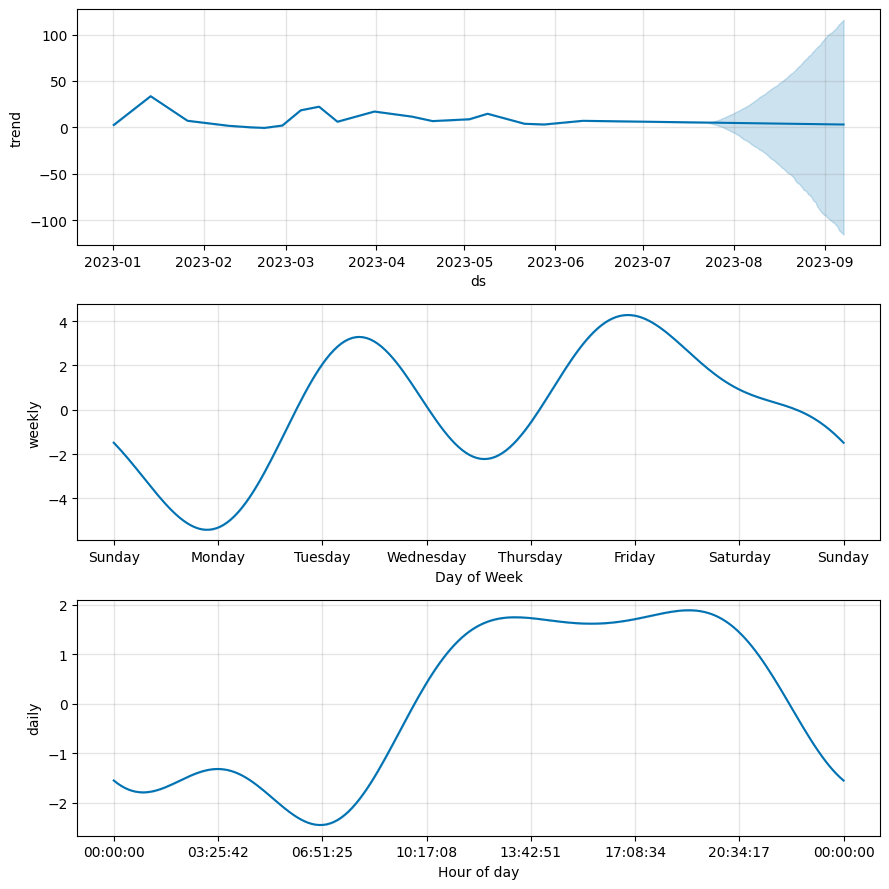

RMSE: 22.422429426372585
MAE: 14.05093934013019


In [20]:
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prophet requires a DataFrame with 'ds' (date) and 'y' (target variable)
prophet_df = df.reset_index().rename(columns={'timestamp': 'ds', 'percentage': 'y'})
prophet_train = prophet_df.iloc[:len(X_train)]
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Create future dataframe and predict
future = prophet_model.make_future_dataframe(periods=len(X_test), freq='5min')
forecast = prophet_model.predict(future)

# Evaluate Prophet model
rmse_prophet = np.sqrt(mean_squared_error(prophet_df['y'][-len(X_test):], forecast['yhat'][-len(X_test):]))
print("Prophet RMSE:", rmse_prophet)

# Perform cross-validation
# Here 'period' is the time between each training period and 'horizon' is how far we forecast into the future
df_cv = cross_validation(prophet_model, initial='30 days', period='10 days', horizon='15 days')

# Compute performance metrics
df_p = performance_metrics(df_cv)
print(df_p.head())


# Actual vs Predicted Plot
fig1 = prophet_model.plot(forecast)
plt.title('Actual vs Forecast')
plt.show()

# Components of the forecast
fig2 = prophet_model.plot_components(forecast)  # Use the forecast DataFrame for components
plt.show()

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


In [14]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, preds)))


XGBoost RMSE: 25.15580297020233


In [15]:
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train, y_train)
lgb_preds = lgb_reg.predict(X_test)
print("LightGBM RMSE:", np.sqrt(mean_squared_error(y_test, lgb_preds)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 56458, number of used features: 5
[LightGBM] [Info] Start training from score 9.346132
LightGBM RMSE: 24.796743183997286


In [ ]:
# # Reshaping input data for LSTM
# X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# # Building LSTM Model
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# # Fit model
# model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, verbose=0)
# lstm_preds = model.predict(X_test_reshaped)
# print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, lstm_preds)))
